In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

##### Goals
- Give a unique ID to every unique address and match the IDs that have been geocoded
- Also need combine geo back to dfs

##### Notes
- Naming of files for each year: one with all cleaned MOUDs, one with geocoded(-islands,+unique ID, + lat/long)

## Assign ID
1. ID setup: hash(address) + state + zip

In [26]:
def create_id(row):
    addr = '' if pd.isna(row['ADDRESS']) else str(row['ADDRESS']) #address
    s = int(hashlib.sha256((addr).lower().encode('utf-8')).hexdigest(), 16) % 10**4 #only keep last 4 digits
    n1 = 'XX' if pd.isna(row['STATE']) else row['STATE']
    n2 = '00000' if pd.isna(row['ZIP']) else str(int(str(row['ZIP']).split('.')[0].split('-')[0])).zfill(5)
    return str(s).zfill(4) + n1 + n2

2. Check effectiveness of ID
- Single year
- Between two years

In [27]:
df17geo = pd.read_csv('2017/2017_c_geocoded.csv')
df17geo['ID2'] = df17geo.apply(create_id, axis = 1)
df15geo = pd.read_csv('2015/2015_c_geocoded.csv')
df15geo['ID2'] = df15geo.apply(create_id, axis = 1)

In [28]:
print("Number of columns:\t", len(df17geo))
print("Number of unique ID:\t", len(set(df17geo['ID2'])))

Number of columns:	 12031
Number of unique ID:	 11530


In [16]:
df15geo[df15geo['ID2'].isin(set(df17geo['ID2']))].reset_index(drop = True)

,ID,ADDRESS,CITY,STATE,ZIP,Longitude,Latitude,Match Score,ID2
0,SpectraCare,219 Dothan Road,Abbeville,AL,36310,-85.252888,31.553425,100.0,1501AL36310
1,Shelby County Treatment Center,750 Highway 31 South,Alabaster,AL,35007,-86.787385,33.213457,100.0,4858AL35007
2,Lighthouse of Tallapoosa County Inc,36 Franklin Street,Alexander City,AL,35010,-85.950922,32.945359,100.0,8795AL35010
3,Anniston Fellowship House Inc,106 East 22nd Street,Anniston,AL,36201,-85.827890,33.672923,100.0,9602AL36201
4,Family Life Center,410 South Jefferson Street,Athens,AL,35611,-86.972423,34.799482,100.0,9461AL35611
...,...,...,...,...,...,...,...,...,...
9211,Mountains Edge Counseling,44 South Main Street,Sheridan,WY,82801,-106.955939,44.796531,100.0,9895WY82801
9212,Volunteers of America Northern Rockies,360 College Meadows Drive,Sheridan,WY,82801,-106.950601,44.759063,100.0,2589WY82801
9213,Peak Wellness Center,501 Albany Avenue,Torrington,WY,82240,-104.190737,42.083805,100.0,0285WY82240
9214,Peak Wellness Center,1954 West Mariposa Parkway,Wheatland,WY,82201,-104.969315,42.046687,100.0,1695WY82201


In [17]:
len(df15geo)

11928

3. Number of rows needing geocode

In [34]:
def create_id_raw(row):
    addr = '' if pd.isna(row['Address1']) else str(row['Address1']) #address
    s = int(hashlib.sha256((addr).lower().encode('utf-8')).hexdigest(), 16) % 10**4 #only keep last 4 digits
    n1 = 'XX' if pd.isna(row['State']) else row['State']
    n2 = '00000' if pd.isna(row['ZIP_Code']) else str(int(str(row['ZIP_Code']).split('.')[0].split('-')[0])).zfill(5)
    return str(s).zfill(4) + n1 + n2

In [63]:
#total number of ids
delete_states = ['HI', 'AK', 'PR', 'VI', 'GU', 'AS', 'MP', 'FM', 'PW', 'MH'] #only concerned with mainland
years = [1980, 1990, 1998, 2000, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2015, 2017]
a = set()
num_new_ids = []
num_ids = []
len_dfs = []
for year in years:
    df = pd.read_csv('{0}/{0}_c.csv'.format(year))
    df[~df['State'].isin(delete_states)].reset_index(drop = True) #remove irrelevant states
    df['ID'] = df.apply(create_id_raw, axis = 1)
    len_prev = len(a)
    a.update(set(list(df['ID'])))
    print("Year {0} has {1}/{2} new IDs".format(year ,len(a) - len_prev, len(df)))
    num_new_ids.append(len(a) - len_prev)
    num_ids.append(len(set(list(df['ID']))))
    len_dfs.append(len(df))

Year 1980 has 3016/3166 new IDs
Year 1990 has 9439/10655 new IDs
Year 1998 has 8645/11324 new IDs
Year 2000 has 5168/12223 new IDs
Year 2003 has 3754/11591 new IDs
Year 2005 has 2628/11060 new IDs
Year 2006 has 1363/10777 new IDs
Year 2007 has 1265/10973 new IDs
Year 2008 has 1600/11265 new IDs
Year 2009 has 1282/11259 new IDs
Year 2010 has 1591/11248 new IDs
Year 2011 has 1399/11278 new IDs
Year 2012 has 1405/11542 new IDs
Year 2015 has 3154/11928 new IDs
Year 2017 has 2313/12031 new IDs


In [53]:
len(a)

48022

<BarContainer object of 15 artists>

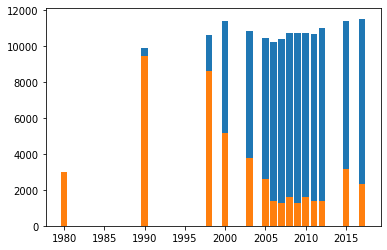

In [66]:
plt.bar(years, num_ids)
plt.bar(years, num_new_ids)

In [55]:
#total ids that has been geocoded
b = set()
for year in [2009, 2015, 2017]:
    df = pd.read_csv('{0}/{0}_c.csv'.format(year))
    df[~df['State'].isin(delete_states)].reset_index(drop = True) #remove irrelevant states
    df['ID'] = df.apply(create_id_raw, axis = 1)
    b.update(set(list(df['ID'])))

In [56]:
len(b)

19183

In [57]:
print("Needs geocode:", len(a) - len(b))

Needs geocode: 28839


## Clean tables for geocoding
- Remove islands, assign IDs
- Remove other irrelevant columns but make sure we can combine back...

In [19]:
#2015, 2017, 2019 are geocoded
df17geo = pd.read_csv('2017/2017_c_geocoded.csv')

delete_states = ['HI', 'AK', 'PR', 'VI', 'GU', 'AS', 'MP', 'FM', 'PW', 'MH'] #only concerned with mainland

#2017
df17 = pd.read_csv('2017/2017_c.csv')
df17 = df17[~df17['State'].isin(delete_states)].reset_index(drop = True)

#2010
df10 = pd.read_csv('2010/2010_c.csv')
df10 = df10[~df10['State'].isin(delete_states)].reset_index(drop = True)

#2000
df00 = pd.read_csv('2000/2000_c.csv')
df00 = df00[~df00['State'].isin(delete_states)].reset_index(drop = True)

#1990
df90 = pd.read_csv('1990/1990_c.csv')
df90 = df90[~df90['State'].isin(delete_states)].reset_index(drop = True)

In [20]:
print('Year {0} has {1}/{2} overlap with 2017'.format(2010, len(df10[df10['ID'].isin(set(df17['ID']))].reset_index(drop = True)), len(df10)))

Year 2010 has 3593/10940 overlap with 2017


In [21]:
print('Year {0} has {1}/{2} overlap with 2017'.format(2000, len(df00[df00['ID'].isin(set(df17['ID']))].reset_index(drop = True)), len(df00)))

Year 2000 has 907/11964 overlap with 2017


In [22]:
print('Year {0} has {1}/{2} overlap with 2017'.format(1990, len(df90[df90['ID'].isin(set(df17['ID']))].reset_index(drop = True)), len(df90)))

Year 1990 has 201/10442 overlap with 2017


In [16]:
df17[df17['ID'] == df90['ID'][13]]

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Note,Keys,ID
16,Fellowship House Inc,NaN,NaN,1625 12th Avenue South,NaN,NaN,Birmingham,AL,35205,(205)933-2430,NaN,SAF/SA/HH/MOA/CBT/SACA/TWFA/CMI/MOTI/ANG/RELP/...,7337AL35205


In [9]:
df90[df90['ID'].isin(set(df17['ID']))]

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Keys,ID
13,FELLOWSHIP HOUSE INC,NaN,NaN,1625 12TH AVENUE SOUTH,NaN,NaN,BIRMINGHAM,AL,35205,(205)933-2430,AD/RR/AM/W/Y/A/B/HV/PI/CU/IV/TX/,1901AL35205
24,LIGHTHOUSE INC,NaN,NaN,925 CONVENT ROAD NE,NaN,NaN,CULLMAN,AL,35055,(205)739-2777,AD/RR/TX/,1631AL35055
65,VETERANS AFFAIRS MEDICAL CENTER,ADDICTIONS TREATMENT UNIT,NaN,3701 LOOP ROAD EAST,NaN,NaN,TUSCALOOSA,AL,35404,(205)553-3760TEX2690,AD/OT/RR/W/Y/A/B/HV/CU/IV/EA/TX/PV/,3248AL35404
307,CHANGING ECHOES,NaN,NaN,7632 POOL STATION ROAD,NaN,NaN,ANGELS CAMP,CA,95222,(209)785-3666,AD/RR/W/B/PI/CU/EA/TX/,8192CA95222
310,REACH PROJECT,NaN,NaN,1915 D STREET,NaN,NaN,ANTIOCH,CA,94509,(415)754-3673,DA/AM/W/Y/H/PI/CU/PG/EA/TX/CI/PV/,6414CA94509
...,...,...,...,...,...,...,...,...,...,...,...,...
10149,SAINT AGNES HOSPITAL,ALCOHOL REHABILITATION UNIT,NaN,430 EAST DIVISION STREET,NaN,NaN,FOND DU LAC,WI,54935,(414)929-2300,AD/DT/RR/AM/Y/CU/IV/EA/DW/TX/,2644WI54935
10214,HOPE HAVEN INC,NORTH BAY LODGE,NaN,3602 MEMORIAL DRIVE,NaN,NaN,MADISON,WI,53704,(608)249-2600,AL/RR/TX/,9329WI53704
10303,CLARK COUNTY COMMUNITY SERVICES,NaN,NaN,517 COURT STREET,NaN,NaN,NEILLSVILLE,WI,54456,(715)743-3241,AD/DT/AM/W/Y/DW/TX/CI/PV/,3281WI54456
10341,KINNIC FALLS,ALCOHOL AND DRUG ABUSE SERVICES,NaN,900 SOUTH ORANGE STREET,NaN,NaN,RIVER FALLS,WI,54022,(715)426-5950,AD/RR/TX/,9712WI54022
